In [17]:
%matplotlib inline

In [71]:
import pandas as pd
import numpy as np

In [221]:
air_data = pd.read_csv("datasets/AirQualityUCI.csv", sep=";")

In [222]:
air_data.drop(["Unnamed: 15", "Unnamed: 16"], axis=1, inplace=True)

In [224]:
air_data.dropna(axis=0, inplace=True)

In [225]:
def string_to_float(row):
    for index, value in row.iteritems():
        if (index != "index" and index != "Date" and index != "Time" and not type(value) is float):
            row[index] = float(value.replace(",", "."))
    
    return row
    
air_data = air_data.apply(string_to_float, axis=1)

In [226]:
air_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
Date             9357 non-null object
Time             9357 non-null object
CO(GT)           9357 non-null float64
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null float64
C6H6(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


In [227]:
air_data.head(n=4)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867


In [228]:
air_data = air_data[air_data["T"] != -200]
air_data = air_data[air_data["NO2(GT)"] != -200]
air_data = air_data[air_data["CO(GT)"] != -200]

In [229]:
air_data.reset_index(drop=True, inplace=True)

In [230]:
print(air_data["T"].mean())
print(air_data["T"].std())

17.755323440426537
8.844908952625909


In [231]:
air_data["no2_cat"] = np.ceil(air_data["NO2(GT)"] / 100)

In [232]:
air_data["no2_cat"].value_counts()

2.0    3690
1.0    2910
3.0     335
4.0       6
Name: no2_cat, dtype: int64

In [233]:
from sklearn.model_selection import StratifiedShuffleSplit

In [234]:
shuffle_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=107)

train_set = None
test_set = None

for train_indexes, test_indexes in shuffle_splitter.split(air_data, air_data["no2_cat"]):
    train_set = air_data.loc[train_indexes]
    test_set = air_data.loc[test_indexes]

In [235]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5552 entries, 6056 to 1986
Data columns (total 16 columns):
Date             5552 non-null object
Time             5552 non-null object
CO(GT)           5552 non-null float64
PT08.S1(CO)      5552 non-null float64
NMHC(GT)         5552 non-null float64
C6H6(GT)         5552 non-null float64
PT08.S2(NMHC)    5552 non-null float64
NOx(GT)          5552 non-null float64
PT08.S3(NOx)     5552 non-null float64
NO2(GT)          5552 non-null float64
PT08.S4(NO2)     5552 non-null float64
PT08.S5(O3)      5552 non-null float64
T                5552 non-null float64
RH               5552 non-null float64
AH               5552 non-null float64
no2_cat          5552 non-null float64
dtypes: float64(14), object(2)
memory usage: 737.4+ KB


In [236]:
corr_matrix = train_set.corr()

In [237]:
corr_matrix["CO(GT)"].sort_values(ascending=False)

CO(GT)           1.000000
C6H6(GT)         0.933815
PT08.S2(NMHC)    0.916300
PT08.S1(CO)      0.878526
PT08.S5(O3)      0.856775
NOx(GT)          0.790591
NO2(GT)          0.671948
PT08.S4(NO2)     0.631650
no2_cat          0.585083
NMHC(GT)         0.173520
RH               0.067605
AH               0.065892
T                0.023398
PT08.S3(NOx)    -0.702218
Name: CO(GT), dtype: float64

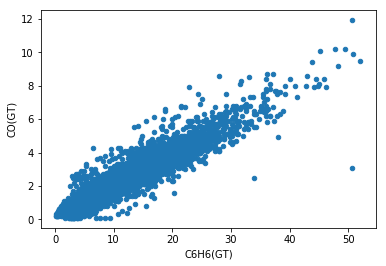

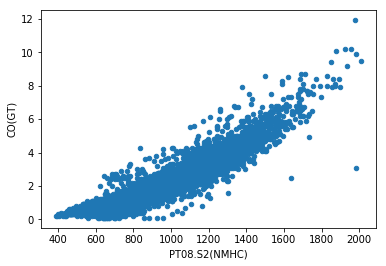

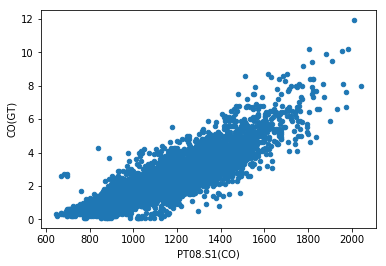

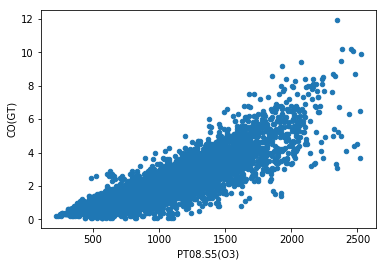

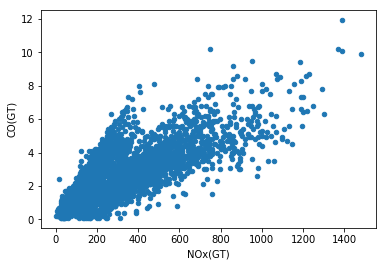

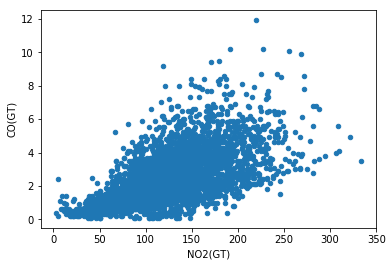

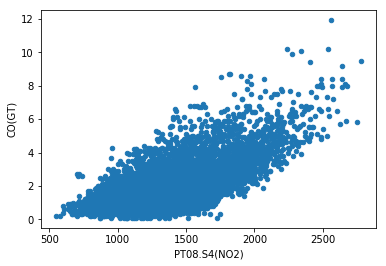

In [238]:
plots = ["C6H6(GT)", "PT08.S2(NMHC)", "PT08.S1(CO)", "PT08.S5(O3)", "NOx(GT)", "NO2(GT)", "PT08.S4(NO2)"]

for plot in plots:
    train_set.plot(kind="scatter", x=plot, y="CO(GT)")

## Linear regression model

In [269]:
from sklearn.preprocessing import StandardScaler

In [283]:
train_set_prepared = train_set.drop(["Date", "Time", "no2_cat", "NMHC(GT)"], axis=1)
train_set_prepared_labels = train_set["CO(GT)"]
train_set_prepared.drop("CO(GT)", axis=1, inplace=True)

train_set_prepared = StandardScaler().fit_transform(train_set_prepared)

In [284]:
train_set_prepared

array([[ 0.12157133, -0.46303414, -0.3742696 , ..., -1.41626098,
         2.00834786, -0.58087473],
       [ 2.15831234,  2.13921325,  1.92549218, ..., -0.4958515 ,
         1.03231763,  0.0856258 ],
       [ 2.02528196,  1.91118126,  1.76989773, ..., -0.8935593 ,
         0.19982126, -0.8643118 ],
       ...,
       [-0.59404037, -0.15452028, -0.0099509 , ...,  0.67454575,
        -0.32838334,  0.65100555],
       [ 0.2362527 , -0.14110663,  0.00522904, ..., -1.38217174,
         0.64764689, -1.08622957],
       [-0.08026787, -0.03379746,  0.11907864, ...,  1.89039532,
        -1.31589627,  1.00766801]])

In [273]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [274]:
regression_model = LinearRegression()

In [275]:
regression_scores = cross_val_score(regression_model, train_set_prepared, train_set_prepared_labels, 
                                   scoring="neg_mean_squared_error", cv=10)

regression_scores_rmse = np.sqrt(-regression_scores)

In [279]:
print(regression_scores_rmse)
print(regression_scores_rmse.mean())
print(regression_scores_rmse.std())

[0.38514963 0.39883436 0.43233626 0.41516557 0.39488376 0.3795909
 0.4707431  0.43584556 0.45117754 0.44719029]
0.4210916985538914
0.02937207200666687


In [277]:
regression_model.fit(train_set_prepared, train_set_prepared_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

## Testing

In [285]:
test_set_prepared = test_set.drop(["Date", "Time", "no2_cat", "NMHC(GT)"], axis=1)
test_set_prepared_labels = test_set["CO(GT)"]
test_set_prepared.drop("CO(GT)", axis=1, inplace=True)

test_set_prepared = StandardScaler().fit_transform(test_set_prepared)

In [286]:
predictions = regression_model.predict(test_set_prepared)

In [287]:
from sklearn.metrics import mean_squared_error

In [289]:
predictions_mse = mean_squared_error(test_set_prepared_labels, predictions)
predictions_rmse = np.sqrt(predictions_mse)

print(predictions_rmse)

0.4757648115133833
